In [26]:
# import the necessary packages
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split

from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import random
import cv2
import os

import warnings
from tqdm import tqdm_notebook as tqdm
import itertools

import tensorflow as tf 
print(tf.__version__)
warnings.filterwarnings("ignore")
SEED = 42   # set random seed

2.12.0


In [27]:
model = Sequential()
model.add(Conv2D(20, (5, 5), padding="same",input_shape=(24,24,3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Flatten())
model.add(Dense(500))
model.add(Activation("relu"))
# softmax classifier
model.add(Dense(3))
model.add(Activation("softmax"))

In [28]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 24, 24, 20)        1520      
                                                                 
 activation_8 (Activation)   (None, 24, 24, 20)        0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 12, 12, 20)       0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 2880)              0         
                                                                 
 dense_4 (Dense)             (None, 500)               1440500   
                                                                 
 activation_9 (Activation)   (None, 500)               0         
                                                      

In [29]:
# create CNN Model
class LeNet:

    @staticmethod
    def build(width, height, depth, classes):
        # initialize the model
        model = Sequential()
        inputShape = (height, width, depth) # (h, h, chanel)

        # if we are using "channels first", update the input shape
        if K.image_data_format() == "channels_first":
            inputShape = (depth, height, width)

        # first set of CONV => RELU => POOL layers
        model.add(Conv2D(20, (5, 5), padding="same",input_shape=inputShape))
        model.add(Activation("relu"))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

        # second set of CONV => RELU => POOL layers
        model.add(Conv2D(50, (5, 5), padding="same"))
        model.add(Activation("relu"))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

        # second set of CONV => RELU => POOL layers
        model.add(Conv2D(100, (5, 5), padding="same"))
        model.add(Activation("relu"))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

        # first (and only) set of FC => RELU layers
        model.add(Flatten())
        model.add(Dense(500))
        model.add(Activation("relu"))

        # softmax classifier
        model.add(Dense(classes))
        model.add(Activation("softmax"))

        # return the constructed network architecture
        return model


In [30]:
DATASET = "train"  # this folde must contain three subfolder with images
MODEL = "Footwear.model" # name to store the model on disk
PLOT = "plot.png" # plot name

In [31]:
EPOCHS = 25
INIT_LR = 1e-3
BS = 32

In [32]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [33]:
import os
os.chdir("/content/drive/MyDrive/DL/exam/PGA Wkend DL Exam/Datasets/CNN/Shoe Classification")

In [34]:
!dir

flagged  test  train


In [35]:
# initialize the data and labels
print("[INFO] loading images...")
data = []
labels = []

# grab the image paths and randomly shuffle them
imagePaths = sorted(list(paths.list_images(DATASET)))
random.seed(42)
random.shuffle(imagePaths)

# progress bar 
with tqdm(total=len(imagePaths)) as pbar:
    
    # loop over the input images
    for idx, imagePath in enumerate(imagePaths):
        # load the image, pre-process it, and store it in the data list
        image = cv2.imread(imagePath)
        image = cv2.resize(image, (28, 28))
        image = img_to_array(image)
        data.append(image)

        # extract the class label from the image path and update the
        # labels list
        label = imagePath.split(os.path.sep)[-2]

        if label == "Boots":
            label = 0
        elif label == "Sandals":
            label = 1
        elif label == "Slippers":
            label = 2

        labels.append(label)
        # update the progressbar
        pbar.update(1)

[INFO] loading images...


  0%|          | 0/778 [00:00<?, ?it/s]

In [36]:
data[0]

array([[[255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.],
        ...,
        [255., 254., 254.],
        [255., 255., 255.],
        [255., 255., 255.]],

       [[255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.],
        ...,
        [ 13.,  20.,  29.],
        [255., 255., 255.],
        [255., 255., 255.]],

       [[255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.],
        ...,
        [186., 178., 180.],
        [255., 255., 255.],
        [255., 255., 255.]],

       ...,

       [[255., 255., 255.],
        [255., 255., 255.],
        [ 20.,  23.,  24.],
        ...,
        [255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.]],

       [[255., 255., 255.],
        [255., 255., 255.],
        [122., 127., 129.],
        ...,
        [255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.]],

       [[255., 255., 255.],
        [255., 255., 255.],
        [253., 2

In [37]:
data[0].shape

(28, 28, 3)

In [38]:
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)

In [39]:
labels

array([1, 0, 0, 1, 0, 0, 2, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 2, 0, 2, 0,
       2, 0, 1, 2, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 2, 1, 1, 0, 2, 1,
       0, 2, 1, 0, 0, 2, 0, 1, 0, 2, 0, 2, 2, 0, 2, 1, 2, 1, 0, 0, 0, 1,
       2, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 2, 0, 1, 2, 2, 0, 0, 0,
       0, 1, 2, 1, 1, 1, 1, 0, 0, 0, 1, 2, 0, 1, 2, 0, 1, 0, 0, 1, 2, 0,
       1, 0, 1, 0, 1, 0, 1, 2, 1, 1, 1, 2, 2, 0, 1, 1, 1, 1, 0, 1, 1, 0,
       1, 1, 1, 1, 1, 2, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1,
       2, 1, 0, 2, 0, 1, 0, 1, 1, 2, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 2,
       0, 1, 0, 2, 1, 1, 2, 2, 2, 1, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1, 0, 1,
       2, 1, 0, 2, 0, 1, 1, 0, 0, 1, 0, 0, 2, 1, 1, 1, 1, 1, 2, 1, 0, 0,
       1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 2, 1, 0, 0, 0, 0, 1, 1, 2, 2,
       1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 2, 0, 0, 0, 2, 2, 2, 0, 1, 2,
       1, 1, 2, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 2, 0, 1, 0,
       0, 0, 2, 1, 0, 0, 0, 2, 2, 1, 1, 1, 0, 1, 2,

In [40]:
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.25, random_state=42)

In [41]:
trainX.shape

(583, 28, 28, 3)

In [42]:
trainY.shape

(583,)

In [43]:
trainY = to_categorical(trainY, num_classes=3)
testY = to_categorical(testY, num_classes=3)

In [44]:


trainY[0]

array([1., 0., 0.], dtype=float32)

Data Preprocessing (Augumentation)

In [45]:
# construct the image generator for data augmentation
aug = ImageDataGenerator(rotation_range=30, 
                         width_shift_range=0.1, 
                         height_shift_range=0.1, 
                         shear_range=0.2, 
                         zoom_range=0.2, 
                         horizontal_flip=True, 
                         fill_mode="nearest")

In [46]:
# initialize the model
print("[INFO] compiling model...")
model = LeNet.build(width=28, height=28, depth=3, classes=3)


opt = Adam(lr=INIT_LR)

model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

print("[INFO] model complied...")
EPOCHS = 50
INIT_LR = 1e-3
BS = 32

[INFO] compiling model...
[INFO] model complied...


In [47]:
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 28, 28, 20)        1520      
                                                                 
 activation_11 (Activation)  (None, 28, 28, 20)        0         
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 14, 14, 20)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 14, 14, 50)        25050     
                                                                 
 activation_12 (Activation)  (None, 14, 14, 50)        0         
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 7, 7, 50)         0         
 2D)                                                  

In [48]:
tf.config.experimental_run_functions_eagerly(True)

In [49]:
# train the network
print("[INFO] training network...")
H = model.fit(x=aug.flow(trainX, trainY, batch_size=BS),
              validation_data=(testX, testY), 
              steps_per_epoch=len(trainX) // BS,
              epochs=100, 
              verbose=1)

[INFO] training network...
Epoch 1/100
18/18 [==============================] - 2s 89ms/step - loss: 1.0164 - accuracy: 0.4755 - val_loss: 0.8330 - val_accuracy: 0.5487
Epoch 2/100
18/18 [==============================] - 2s 90ms/step - loss: 0.7716 - accuracy: 0.6334 - val_loss: 0.5587 - val_accuracy: 0.7026
Epoch 3/100
18/18 [==============================] - 2s 92ms/step - loss: 0.6808 - accuracy: 0.6897 - val_loss: 0.4455 - val_accuracy: 0.7897
Epoch 4/100
18/18 [==============================] - 2s 114ms/step - loss: 0.6255 - accuracy: 0.7169 - val_loss: 0.4504 - val_accuracy: 0.7744
Epoch 5/100
18/18 [==============================] - 2s 89ms/step - loss: 0.5825 - accuracy: 0.7296 - val_loss: 0.4075 - val_accuracy: 0.8308
Epoch 6/100
18/18 [==============================] - 2s 90ms/step - loss: 0.5169 - accuracy: 0.8004 - val_loss: 0.3409 - val_accuracy: 0.8513
Epoch 7/100
18/18 [==============================] - 2s 88ms/step - loss: 0.5001 - accuracy: 0.7768 - val_loss: 0.3386 -

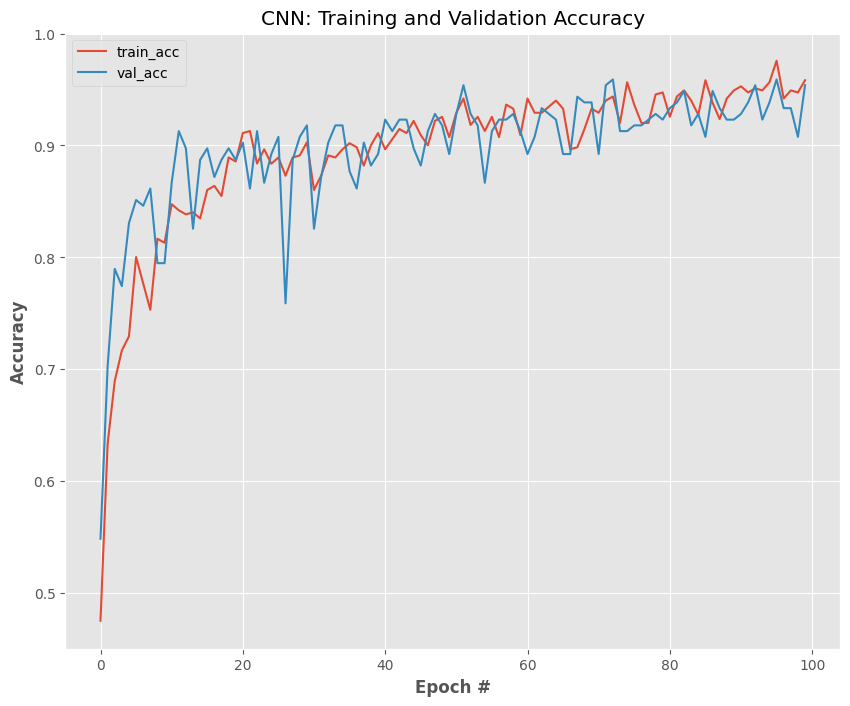

In [58]:
# plot the training and validation accuracy
N = np.arange(0, 100)
plt.style.use("ggplot")
plt.figure(figsize = [10,8])
plt.plot(N, H.history["accuracy"], label="train_acc")
plt.plot(N, H.history["val_accuracy"], label="val_acc")
plt.title("CNN: Training and Validation Accuracy")
plt.xlabel("Epoch #", weight="bold")
plt.ylabel("Accuracy", weight="bold")
plt.legend()
plt.show()

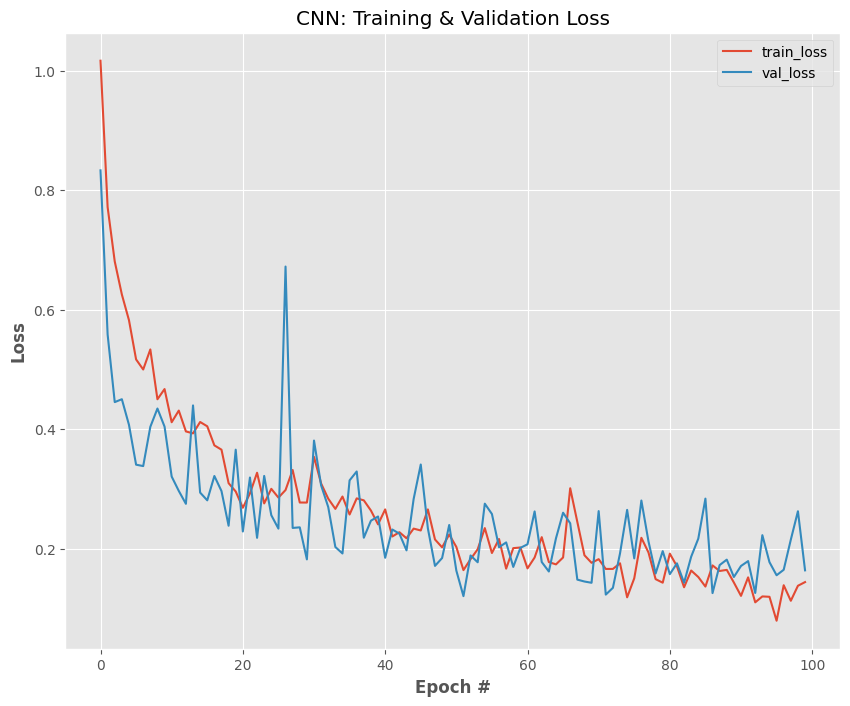

In [59]:
# plot the training and validation loss
N = np.arange(0, 100)
plt.style.use("ggplot")
plt.figure(figsize = [10,8])
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.title("CNN: Training & Validation Loss")
plt.xlabel("Epoch #", weight="bold")
plt.ylabel("Loss", weight="bold")
plt.legend()
plt.show()

In [54]:
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
import numpy as np
import argparse
import imutils
import cv2
import matplotlib.pyplot as plt
from imutils import paths
%matplotlib inline

In [55]:
def display_img(img):
    fig = plt.figure(figsize=(12,10))
    plt.grid(b=None)
    ax = fig.add_subplot(111)

    ax.imshow(img)

In [56]:
!dir


flagged  test  train


In [57]:
from tqdm import tqdm

In [60]:
#model = load_model('Shoe Classification')

[INFO] loading network and...


  0%|          | 0/89 [00:00<?, ?it/s]

1/1 [==============================] - 0s 139ms/step


  1%|          | 1/89 [00:00<01:08,  1.28it/s]

[3.26470975e-08 9.99882579e-01 1.17386306e-04]
1/1 [==============================] - 0s 27ms/step


  2%|▏         | 2/89 [00:01<01:03,  1.37it/s]

[9.7546965e-01 2.4518812e-02 1.1555250e-05]
1/1 [==============================] - 0s 26ms/step


  3%|▎         | 3/89 [00:02<00:59,  1.45it/s]

[9.9999487e-01 5.1851221e-06 4.3688175e-10]
1/1 [==============================] - 0s 27ms/step


  4%|▍         | 4/89 [00:02<00:57,  1.49it/s]

[3.0150551e-07 1.4595652e-06 9.9999821e-01]
1/1 [==============================] - 0s 26ms/step


  6%|▌         | 5/89 [00:03<00:55,  1.50it/s]

[9.9998927e-01 1.0677124e-05 2.5204788e-11]
1/1 [==============================] - 0s 27ms/step


  7%|▋         | 6/89 [00:04<00:55,  1.51it/s]

[0.00904618 0.50460076 0.48635304]
1/1 [==============================] - 0s 29ms/step


  8%|▊         | 7/89 [00:04<00:53,  1.54it/s]

[1.0000000e+00 3.3726472e-08 1.1471630e-13]
1/1 [==============================] - 0s 27ms/step
[9.9373879e-05 9.9989903e-01 1.5531182e-06]


  9%|▉         | 8/89 [00:48<19:20, 14.33s/it]

1/1 [==============================] - 0s 39ms/step


 10%|█         | 9/89 [00:49<13:25, 10.07s/it]

[1.4701074e-03 9.9837673e-01 1.5321637e-04]
1/1 [==============================] - 0s 27ms/step


 11%|█         | 10/89 [00:49<09:25,  7.16s/it]

[9.9999988e-01 1.6200242e-07 4.9823024e-15]
1/1 [==============================] - 0s 25ms/step


 12%|█▏        | 11/89 [00:50<06:43,  5.18s/it]

[1.0000000e+00 1.0918976e-08 9.5534980e-17]
1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 12/89 [00:51<04:53,  3.81s/it]

[9.7852170e-01 2.1477846e-02 5.0058605e-07]
1/1 [==============================] - 0s 28ms/step


 15%|█▍        | 13/89 [00:51<03:36,  2.85s/it]

[9.9994457e-01 5.5481843e-05 3.9231024e-10]
1/1 [==============================] - 0s 27ms/step


 16%|█▌        | 14/89 [00:52<02:44,  2.20s/it]

[3.0437373e-05 9.9865627e-01 1.3132141e-03]
1/1 [==============================] - 0s 30ms/step


 17%|█▋        | 15/89 [00:53<02:08,  1.74s/it]

[2.8432661e-04 9.9943763e-01 2.7806722e-04]
1/1 [==============================] - 0s 27ms/step


 18%|█▊        | 16/89 [00:53<01:43,  1.42s/it]

[9.9649554e-01 3.4855274e-03 1.8863448e-05]
1/1 [==============================] - 0s 30ms/step


 19%|█▉        | 17/89 [00:54<01:26,  1.20s/it]

[9.9999976e-01 2.3871064e-07 5.8630916e-14]
1/1 [==============================] - 0s 25ms/step


 20%|██        | 18/89 [00:55<01:14,  1.04s/it]

[9.8368246e-04 9.9881566e-01 2.0065811e-04]
1/1 [==============================] - 0s 27ms/step


 21%|██▏       | 19/89 [00:55<01:04,  1.09it/s]

[9.9990273e-01 9.7297649e-05 6.9743455e-10]
1/1 [==============================] - 0s 27ms/step


 22%|██▏       | 20/89 [00:56<00:58,  1.19it/s]

[1.0000000e+00 1.3594251e-08 2.2032777e-14]
1/1 [==============================] - 0s 27ms/step


 24%|██▎       | 21/89 [00:57<00:53,  1.26it/s]

[9.9999964e-01 2.9804357e-07 2.4750644e-12]
1/1 [==============================] - 0s 27ms/step


 25%|██▍       | 22/89 [00:57<00:50,  1.34it/s]

[9.9999988e-01 1.4992766e-07 2.3962877e-14]
1/1 [==============================] - 0s 26ms/step


 26%|██▌       | 23/89 [00:58<00:47,  1.39it/s]

[1.7338018e-04 2.9493103e-04 9.9953175e-01]
1/1 [==============================] - 0s 32ms/step


 27%|██▋       | 24/89 [00:59<00:45,  1.41it/s]

[2.6377009e-05 1.9396036e-03 9.9803406e-01]
1/1 [==============================] - 0s 38ms/step


 28%|██▊       | 25/89 [00:59<00:44,  1.43it/s]

[9.991763e-01 8.237024e-04 8.207234e-09]
1/1 [==============================] - 0s 42ms/step


 29%|██▉       | 26/89 [01:00<00:45,  1.39it/s]

[9.9999619e-01 3.7984955e-06 3.5977679e-11]
1/1 [==============================] - 0s 40ms/step


 30%|███       | 27/89 [01:01<00:43,  1.43it/s]

[1.0000000e+00 7.8756573e-10 1.6271200e-17]
1/1 [==============================] - 0s 25ms/step


 31%|███▏      | 28/89 [01:01<00:42,  1.45it/s]

[1.0000000e+00 5.2289316e-08 2.4722603e-14]
1/1 [==============================] - 0s 25ms/step


 33%|███▎      | 29/89 [01:02<00:43,  1.39it/s]

[9.9999976e-01 2.8094846e-07 1.3867352e-14]
1/1 [==============================] - 0s 24ms/step


 34%|███▎      | 30/89 [01:03<00:41,  1.41it/s]

[9.9999714e-01 2.8247355e-06 3.3235653e-10]
1/1 [==============================] - 0s 26ms/step


 35%|███▍      | 31/89 [01:03<00:39,  1.47it/s]

[9.9998736e-01 1.2680899e-05 1.8730244e-08]
1/1 [==============================] - 0s 41ms/step


 36%|███▌      | 32/89 [01:04<00:41,  1.37it/s]

[9.99999881e-01 1.03311613e-07 1.26723024e-11]
1/1 [==============================] - 0s 91ms/step


 37%|███▋      | 33/89 [01:05<00:43,  1.30it/s]

[9.9785656e-01 2.1434226e-03 1.3872849e-08]
1/1 [==============================] - 0s 26ms/step


 38%|███▊      | 34/89 [01:06<00:40,  1.35it/s]

[9.9992883e-01 7.1176975e-05 1.8398946e-11]
1/1 [==============================] - 0s 26ms/step


 39%|███▉      | 35/89 [01:06<00:37,  1.43it/s]

[1.0000000e+00 7.2135714e-10 2.9193501e-16]
1/1 [==============================] - 0s 30ms/step


 40%|████      | 36/89 [01:07<00:36,  1.44it/s]

[2.7078953e-05 9.9932349e-01 6.4946112e-04]
1/1 [==============================] - 0s 24ms/step


 42%|████▏     | 37/89 [01:08<00:35,  1.45it/s]

[1.6002335e-04 9.0915132e-01 9.0688661e-02]
1/1 [==============================] - 0s 33ms/step


 43%|████▎     | 38/89 [01:08<00:34,  1.48it/s]

[3.3812275e-09 9.9999309e-01 6.9095518e-06]
1/1 [==============================] - 0s 25ms/step


 44%|████▍     | 39/89 [01:09<00:33,  1.48it/s]

[2.1201447e-06 9.9985659e-01 1.4123815e-04]
1/1 [==============================] - 0s 26ms/step


 45%|████▍     | 40/89 [01:10<00:32,  1.49it/s]

[8.1470923e-04 3.6877997e-02 9.6230733e-01]
1/1 [==============================] - 0s 26ms/step


 46%|████▌     | 41/89 [01:10<00:31,  1.53it/s]

[1.4359360e-04 9.9979275e-01 6.3629705e-05]
1/1 [==============================] - 0s 26ms/step


 47%|████▋     | 42/89 [01:11<00:30,  1.52it/s]

[8.9946797e-09 9.9998641e-01 1.3629812e-05]
1/1 [==============================] - 0s 39ms/step


 48%|████▊     | 43/89 [01:12<00:31,  1.47it/s]

[6.9123757e-04 9.9869162e-01 6.1717629e-04]
1/1 [==============================] - 0s 37ms/step


 49%|████▉     | 44/89 [01:12<00:30,  1.46it/s]

[0.00691852 0.05989866 0.93318284]
1/1 [==============================] - 0s 57ms/step


 51%|█████     | 45/89 [01:13<00:31,  1.38it/s]

[2.4364562e-01 7.5635302e-01 1.3332960e-06]
1/1 [==============================] - 0s 25ms/step


 52%|█████▏    | 46/89 [01:14<00:30,  1.43it/s]

[6.1806531e-08 9.9995005e-01 4.9871749e-05]
1/1 [==============================] - 0s 27ms/step


 53%|█████▎    | 47/89 [01:15<00:28,  1.46it/s]

[0.001946   0.04935789 0.9486961 ]
1/1 [==============================] - 0s 24ms/step


 54%|█████▍    | 48/89 [01:15<00:27,  1.50it/s]

[6.5539978e-05 4.0160647e-01 5.9832805e-01]
1/1 [==============================] - 0s 27ms/step


 55%|█████▌    | 49/89 [01:16<00:26,  1.50it/s]

[1.30585744e-04 1.01676546e-01 8.98192883e-01]
1/1 [==============================] - 0s 25ms/step


 56%|█████▌    | 50/89 [01:16<00:25,  1.51it/s]

[1.5130772e-09 2.5614017e-07 9.9999976e-01]
1/1 [==============================] - 0s 35ms/step


 57%|█████▋    | 51/89 [01:17<00:25,  1.50it/s]

[2.5582006e-08 7.4405936e-05 9.9992561e-01]
1/1 [==============================] - 0s 28ms/step


 58%|█████▊    | 52/89 [01:18<00:28,  1.29it/s]

[1.0404043e-04 5.2080655e-01 4.7908938e-01]
1/1 [==============================] - 0s 25ms/step


 60%|█████▉    | 53/89 [01:19<00:26,  1.34it/s]

[1.0000000e+00 1.6293635e-08 6.0248453e-13]
1/1 [==============================] - 0s 29ms/step


 61%|██████    | 54/89 [01:20<00:25,  1.38it/s]

[7.4869753e-08 9.9997389e-01 2.6031299e-05]
1/1 [==============================] - 0s 28ms/step


 62%|██████▏   | 55/89 [01:20<00:24,  1.41it/s]

[0.09922072 0.8900807  0.01069868]
1/1 [==============================] - 0s 26ms/step


 63%|██████▎   | 56/89 [01:21<00:23,  1.42it/s]

[8.5617357e-06 9.9688774e-01 3.1036735e-03]
1/1 [==============================] - 0s 25ms/step


 64%|██████▍   | 57/89 [01:22<00:22,  1.43it/s]

[2.7181234e-04 6.6613603e-01 3.3359215e-01]
1/1 [==============================] - 0s 28ms/step


 65%|██████▌   | 58/89 [01:22<00:20,  1.48it/s]

[9.9993002e-01 6.9915826e-05 4.5055240e-09]
1/1 [==============================] - 0s 30ms/step


 66%|██████▋   | 59/89 [01:23<00:20,  1.46it/s]

[0.27134112 0.6270621  0.10159683]
1/1 [==============================] - 0s 52ms/step


 67%|██████▋   | 60/89 [01:24<00:20,  1.41it/s]

[2.2349010e-08 1.2942983e-03 9.9870563e-01]
1/1 [==============================] - 0s 45ms/step


 69%|██████▊   | 61/89 [01:25<00:21,  1.32it/s]

[1.7744550e-04 1.7581984e-02 9.8224062e-01]
1/1 [==============================] - 0s 38ms/step


 70%|██████▉   | 62/89 [01:25<00:20,  1.34it/s]

[1.8769451e-05 1.0080908e-02 9.8990029e-01]
1/1 [==============================] - 0s 28ms/step


 71%|███████   | 63/89 [01:26<00:21,  1.23it/s]

[1.9959296e-05 9.8884928e-01 1.1130874e-02]
1/1 [==============================] - 0s 29ms/step


 72%|███████▏  | 64/89 [01:27<00:19,  1.30it/s]

[1.0603080e-07 2.6636977e-07 9.9999964e-01]
1/1 [==============================] - 0s 27ms/step


 73%|███████▎  | 65/89 [01:28<00:17,  1.35it/s]

[1.3344381e-04 1.2596736e-03 9.9860686e-01]
1/1 [==============================] - 0s 26ms/step


 74%|███████▍  | 66/89 [01:28<00:16,  1.41it/s]

[0.00917611 0.12674254 0.8640813 ]
1/1 [==============================] - 0s 30ms/step


 75%|███████▌  | 67/89 [01:29<00:15,  1.46it/s]

[1.6440479e-04 6.6147296e-04 9.9917406e-01]
1/1 [==============================] - 0s 25ms/step


 76%|███████▋  | 68/89 [01:29<00:14,  1.47it/s]

[0.00423486 0.06399394 0.9317713 ]
1/1 [==============================] - 0s 31ms/step


 78%|███████▊  | 69/89 [01:30<00:13,  1.50it/s]

[0.00175849 0.04436083 0.95388067]
1/1 [==============================] - 0s 26ms/step


 79%|███████▊  | 70/89 [01:31<00:12,  1.51it/s]

[1.0167320e-04 6.5341234e-01 3.4648606e-01]
1/1 [==============================] - 0s 26ms/step


 80%|███████▉  | 71/89 [01:31<00:11,  1.52it/s]

[7.1272029e-06 5.2619386e-01 4.7379902e-01]
1/1 [==============================] - 0s 28ms/step


 81%|████████  | 72/89 [01:32<00:11,  1.53it/s]

[1.5685599e-09 9.9999774e-01 2.2864515e-06]
1/1 [==============================] - 0s 29ms/step


 82%|████████▏ | 73/89 [01:33<00:10,  1.53it/s]

[1.0266925e-04 9.8835361e-01 1.1543762e-02]
1/1 [==============================] - 0s 27ms/step


 83%|████████▎ | 74/89 [01:33<00:09,  1.51it/s]

[1.1709077e-04 2.1797221e-02 9.7808576e-01]
1/1 [==============================] - 0s 26ms/step


 84%|████████▍ | 75/89 [01:34<00:09,  1.53it/s]

[5.3517884e-05 9.9909091e-01 8.5562986e-04]
1/1 [==============================] - 0s 29ms/step


 85%|████████▌ | 76/89 [01:35<00:08,  1.52it/s]

[9.9615878e-01 3.8188102e-03 2.2428570e-05]
1/1 [==============================] - 0s 25ms/step


 87%|████████▋ | 77/89 [01:35<00:07,  1.52it/s]

[1.1894542e-03 9.9880946e-01 1.0847484e-06]
1/1 [==============================] - 0s 26ms/step


 88%|████████▊ | 78/89 [01:36<00:07,  1.55it/s]

[5.3421900e-06 3.8501664e-04 9.9960965e-01]
1/1 [==============================] - 0s 40ms/step


 89%|████████▉ | 79/89 [01:37<00:06,  1.49it/s]

[1.4848252e-04 4.1505265e-01 5.8479881e-01]
1/1 [==============================] - 0s 41ms/step


 90%|████████▉ | 80/89 [01:37<00:06,  1.47it/s]

[4.5473269e-05 3.6602392e-04 9.9958855e-01]
1/1 [==============================] - 0s 38ms/step


 91%|█████████ | 81/89 [01:38<00:05,  1.44it/s]

[1.4028905e-03 9.9788266e-01 7.1445503e-04]
1/1 [==============================] - 0s 28ms/step


 92%|█████████▏| 82/89 [01:39<00:04,  1.49it/s]

[1.07439334e-07 9.99999523e-01 3.59060607e-07]
1/1 [==============================] - 0s 26ms/step


 93%|█████████▎| 83/89 [01:39<00:03,  1.52it/s]

[1.1262933e-01 8.8655496e-01 8.1569236e-04]
1/1 [==============================] - 0s 29ms/step


 94%|█████████▍| 84/89 [01:40<00:03,  1.52it/s]

[9.9948788e-01 5.1215419e-04 3.6394706e-08]
1/1 [==============================] - 0s 25ms/step


 96%|█████████▌| 85/89 [01:41<00:02,  1.52it/s]

[5.633576e-05 6.663543e-01 3.335894e-01]
1/1 [==============================] - 0s 27ms/step


 97%|█████████▋| 86/89 [01:41<00:01,  1.51it/s]

[4.2963266e-01 5.7036728e-01 4.3341888e-08]
1/1 [==============================] - 0s 26ms/step


 98%|█████████▊| 87/89 [01:42<00:01,  1.53it/s]

[1.3687236e-04 9.9985480e-01 8.3993500e-06]
1/1 [==============================] - 0s 26ms/step


 99%|█████████▉| 88/89 [01:43<00:00,  1.51it/s]

[9.999999e-01 6.732431e-08 2.593999e-16]
1/1 [==============================] - 0s 28ms/step


100%|██████████| 89/89 [01:43<00:00,  1.17s/it]

[4.7608020e-04 9.9952233e-01 1.5151404e-06]


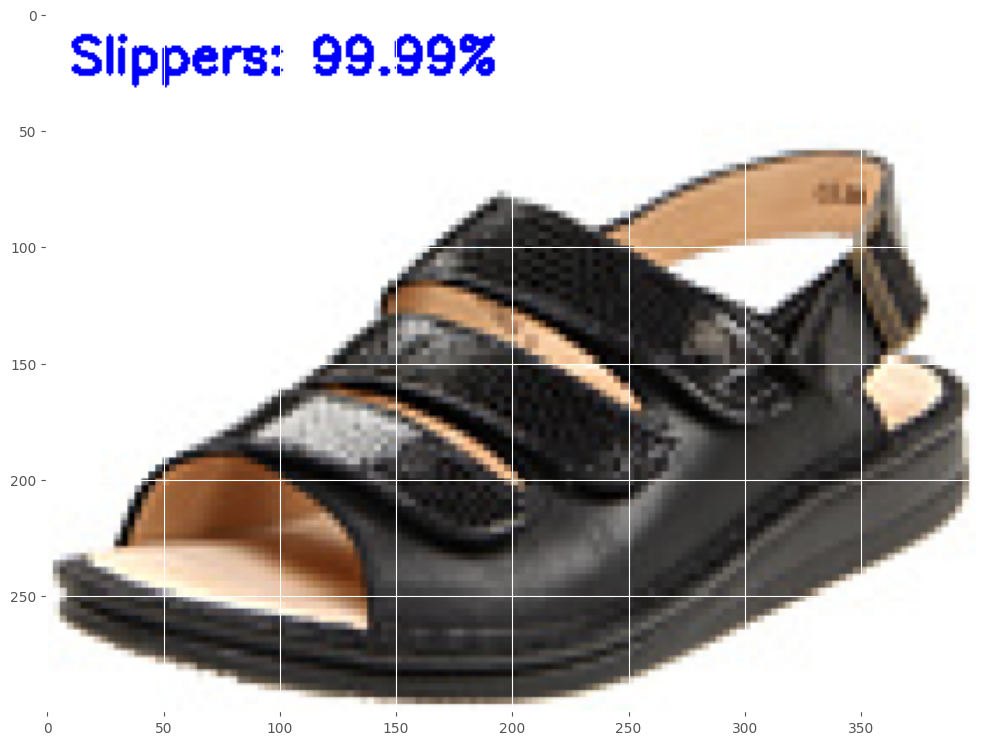

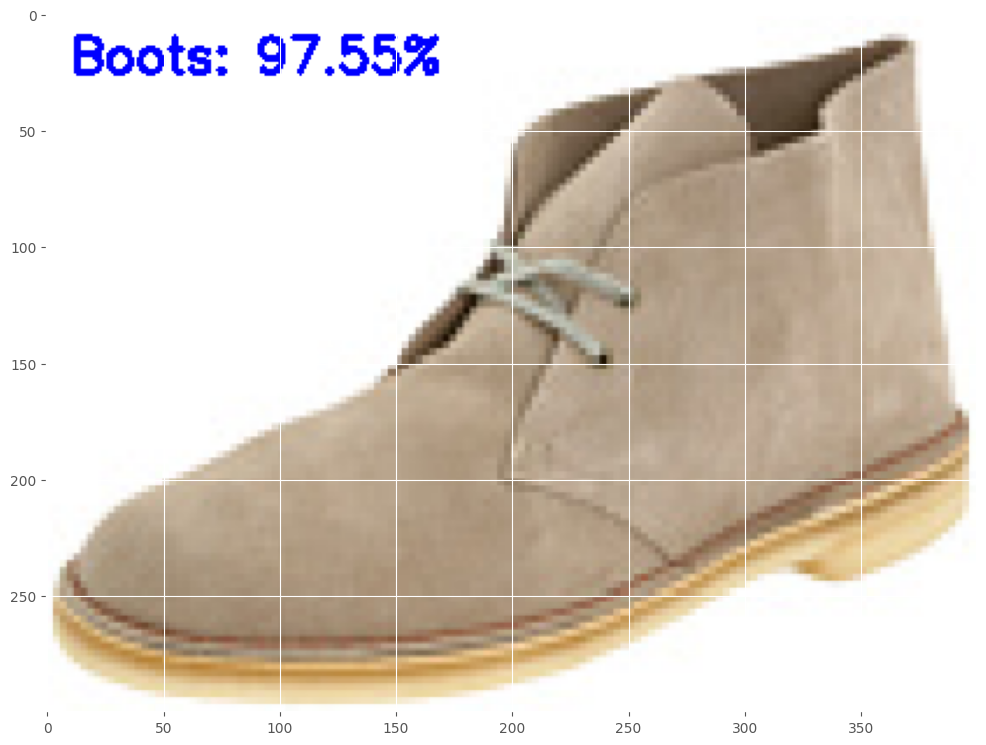

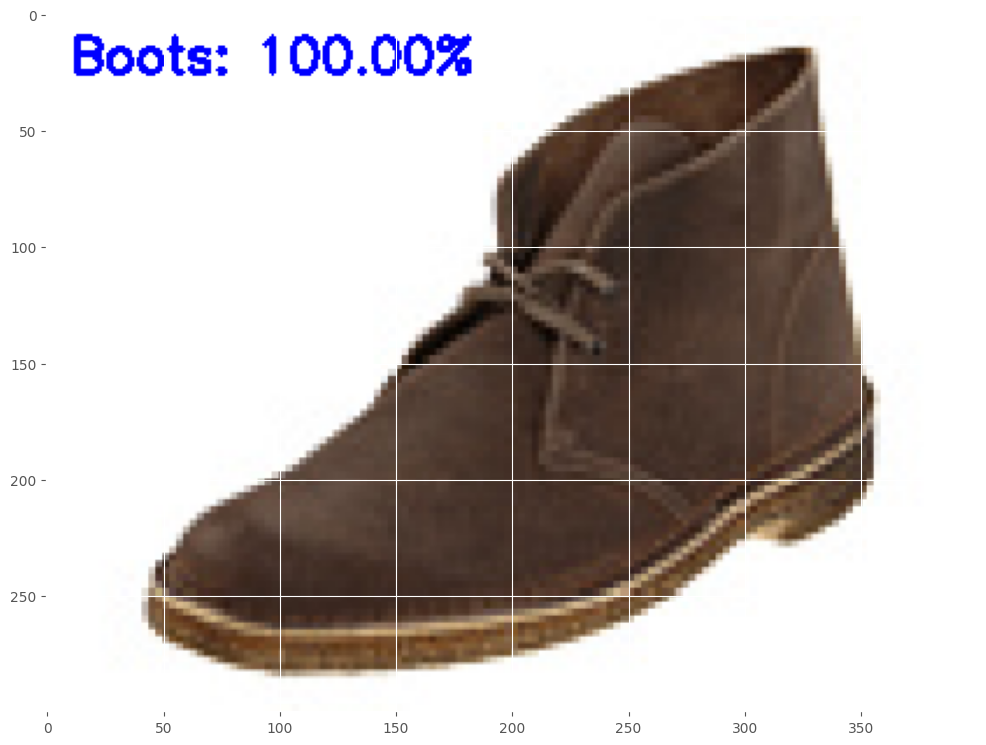

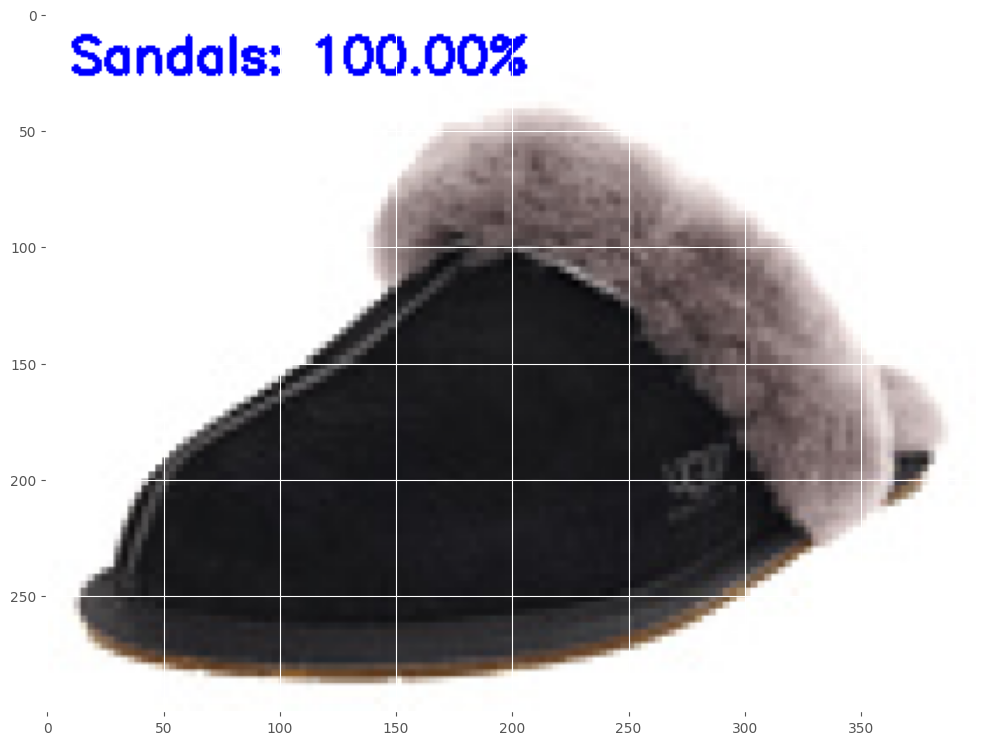

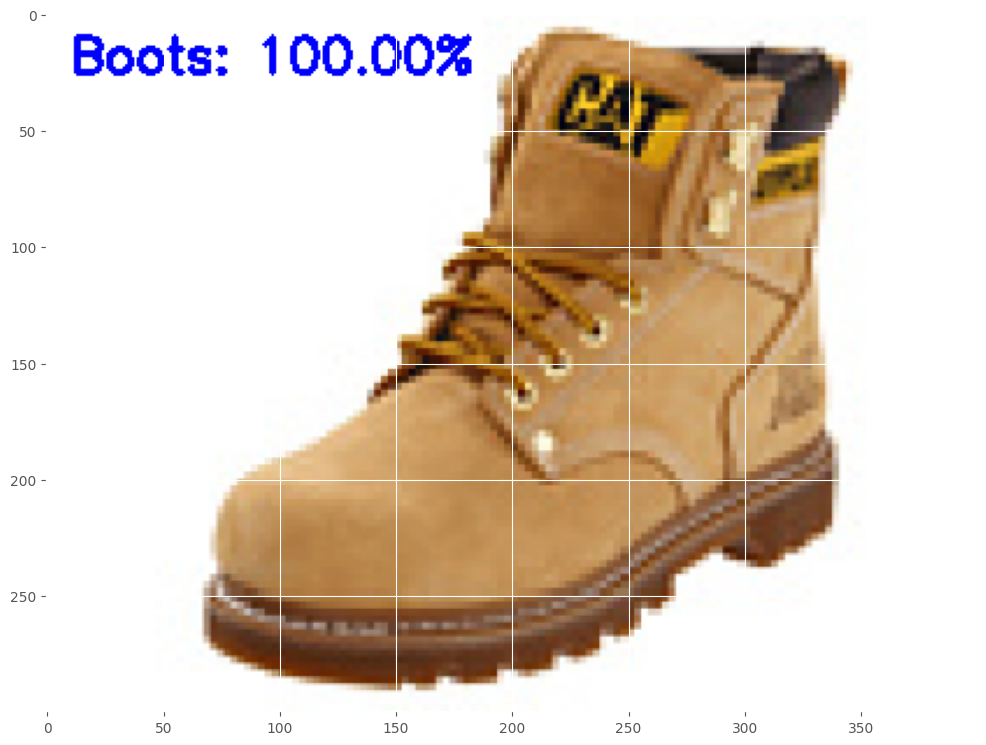

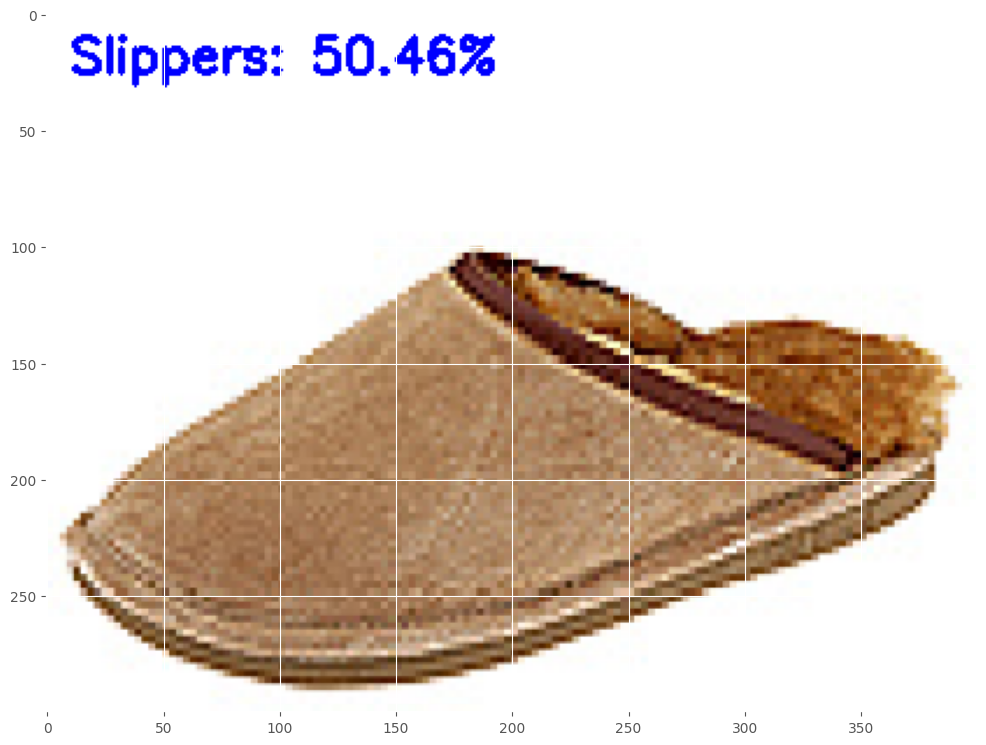

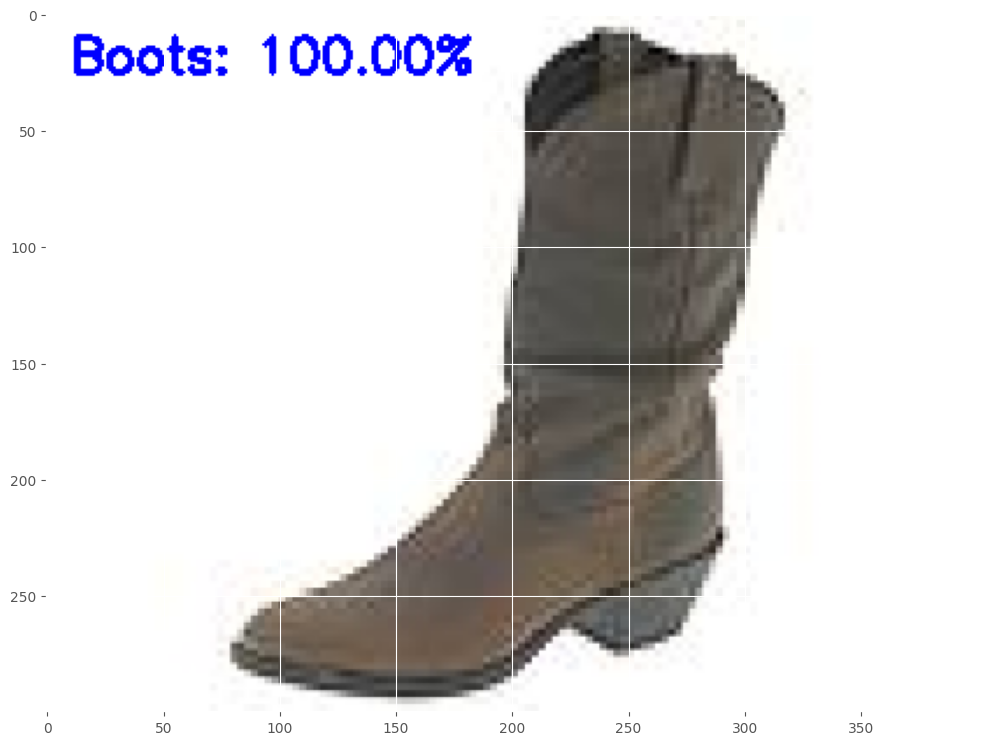

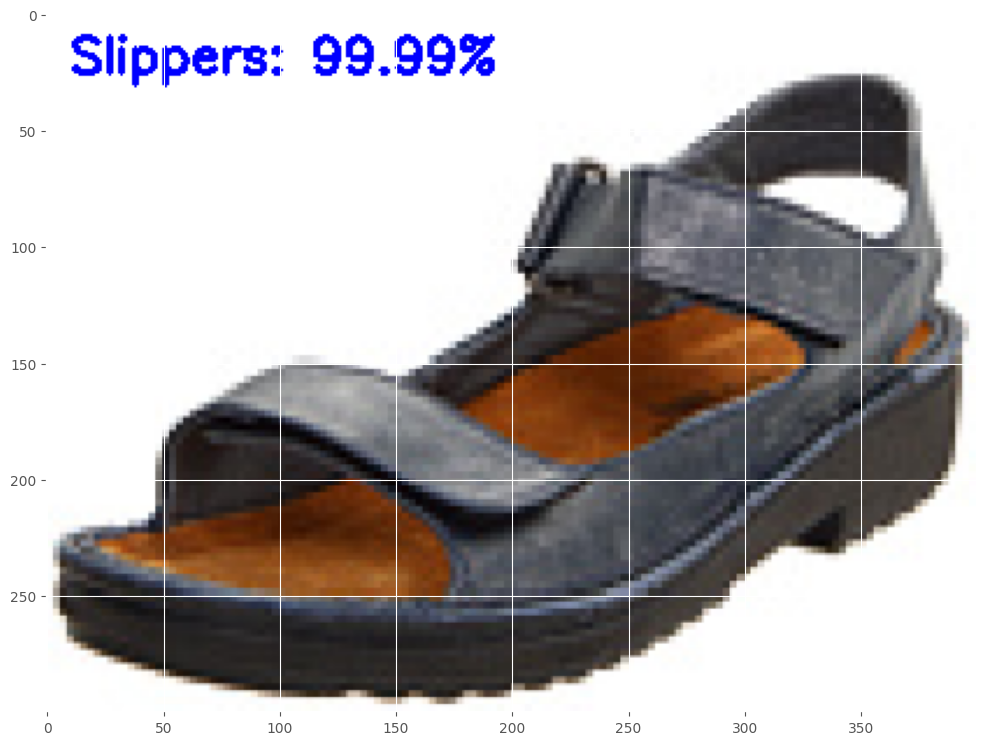

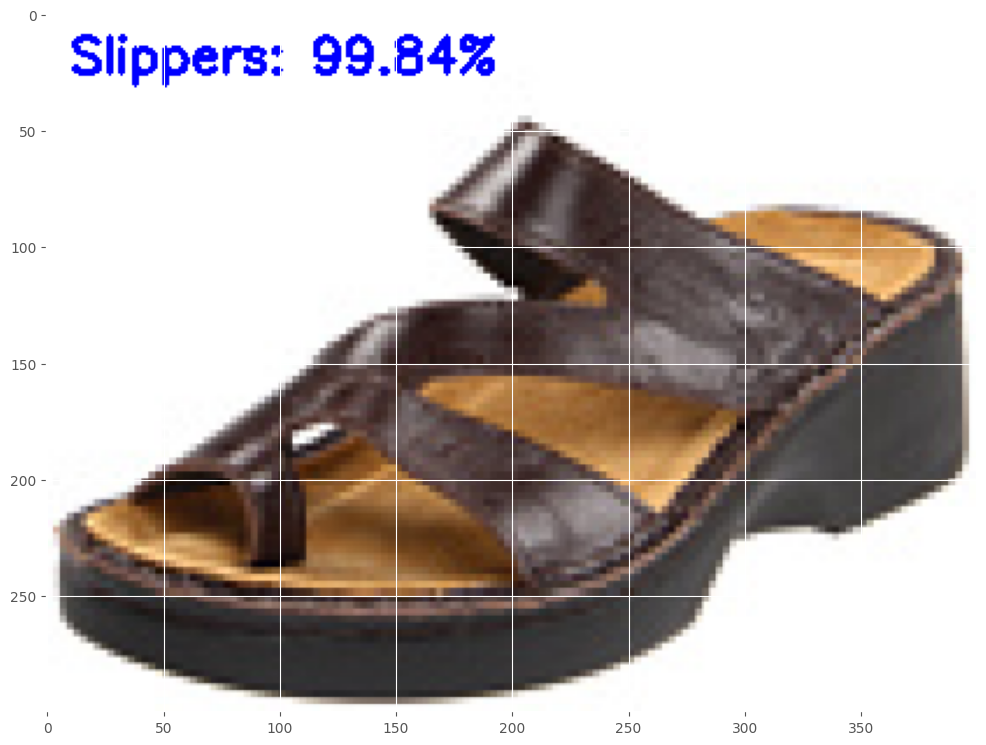

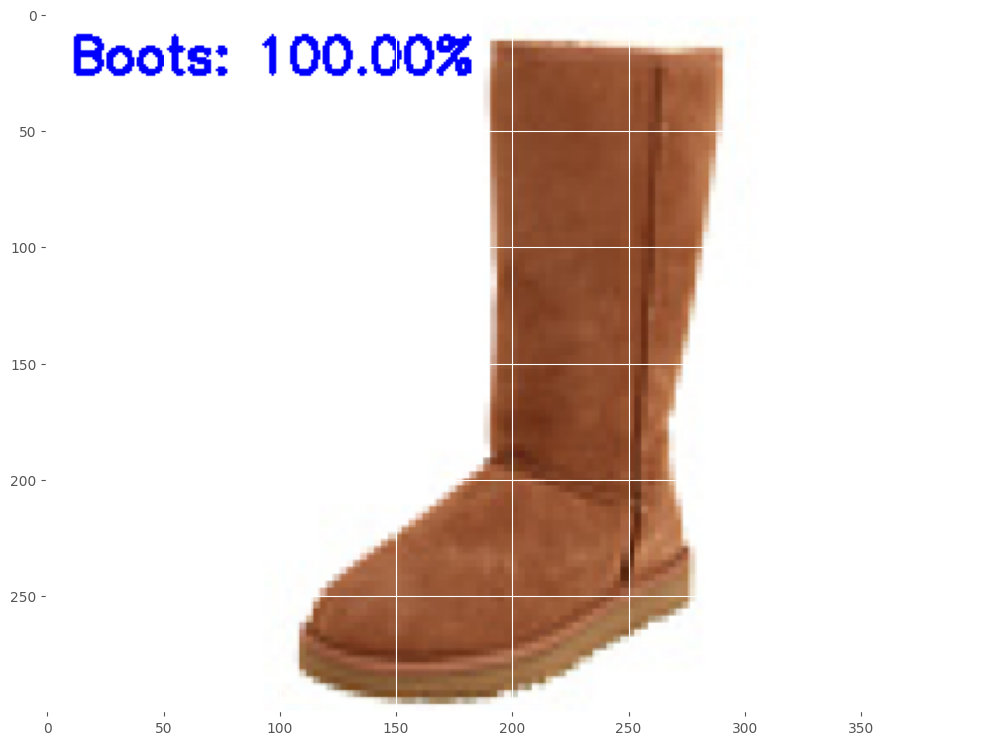

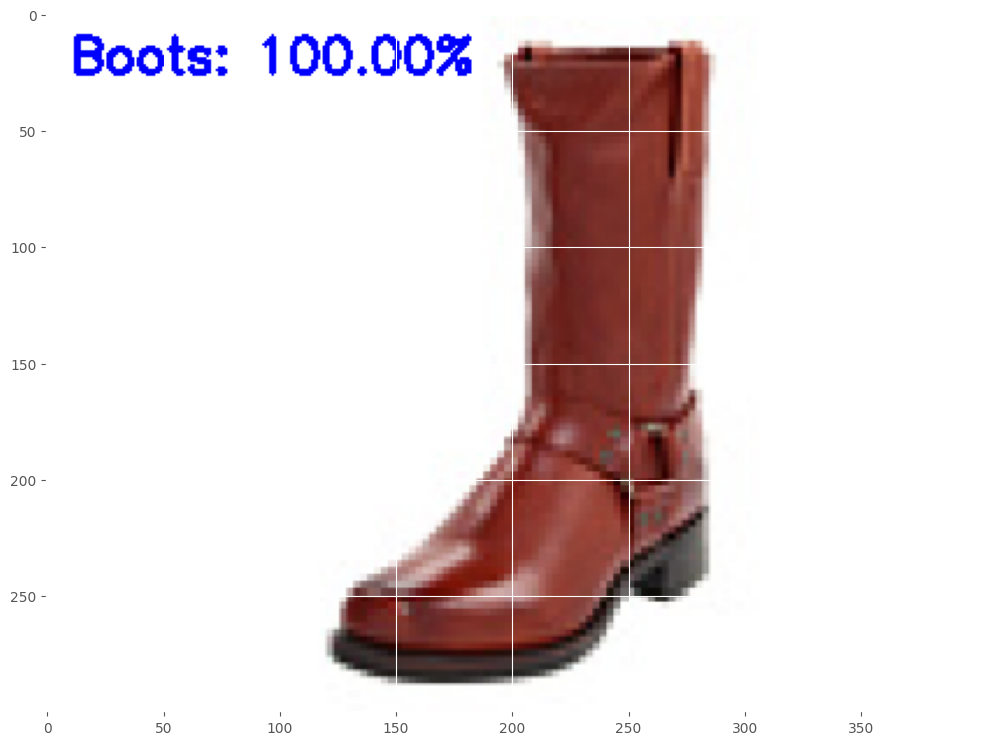

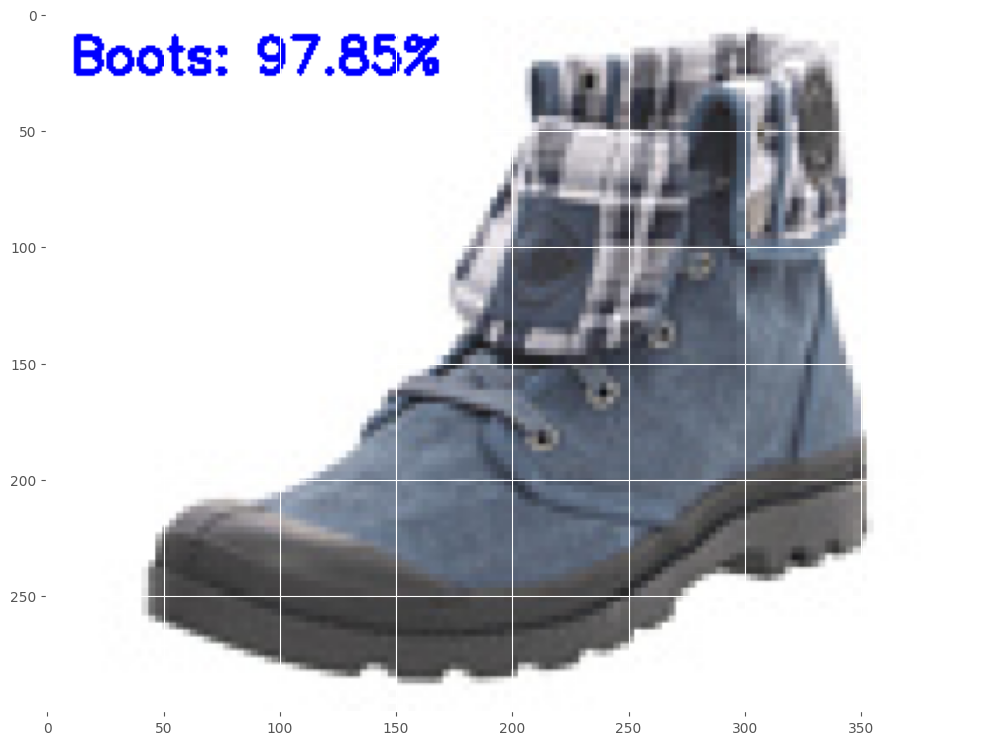

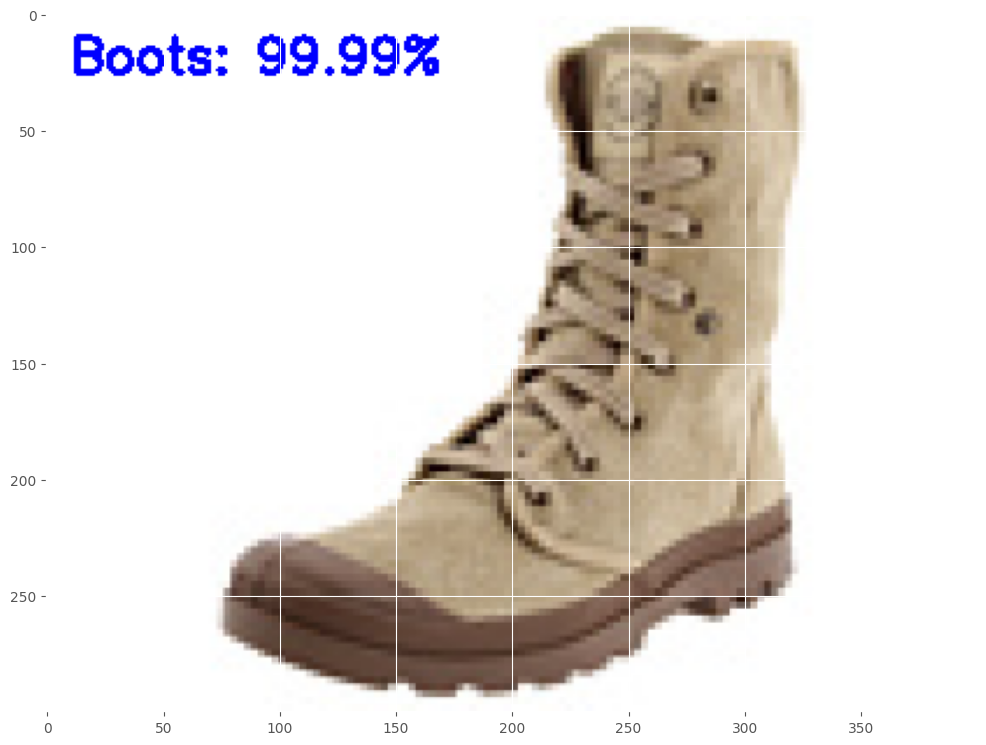

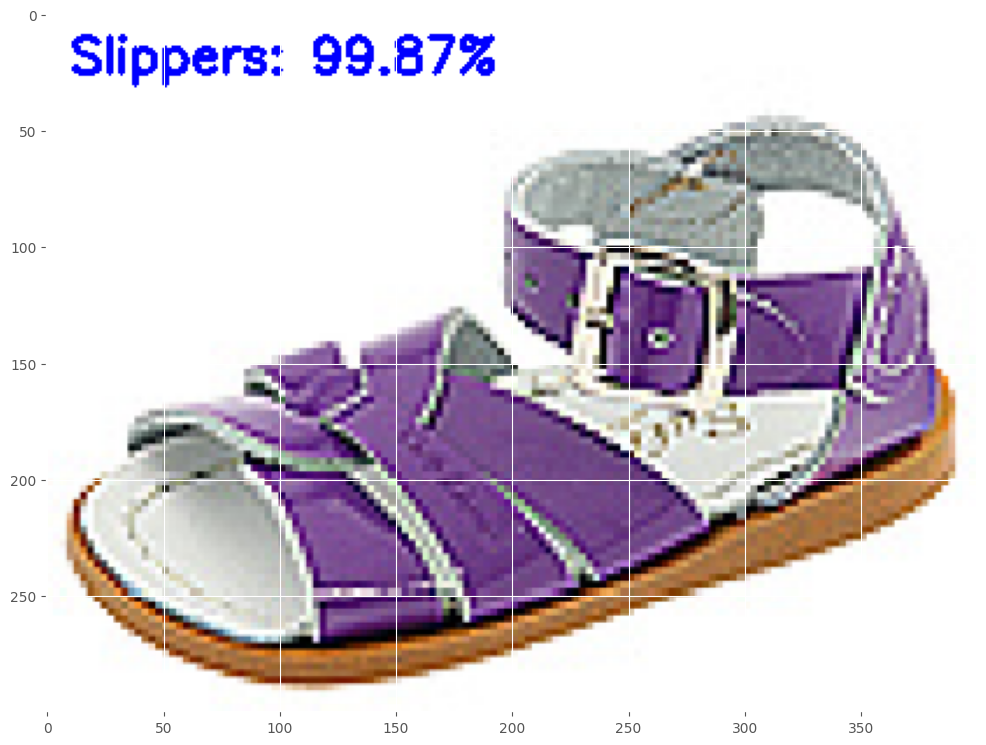

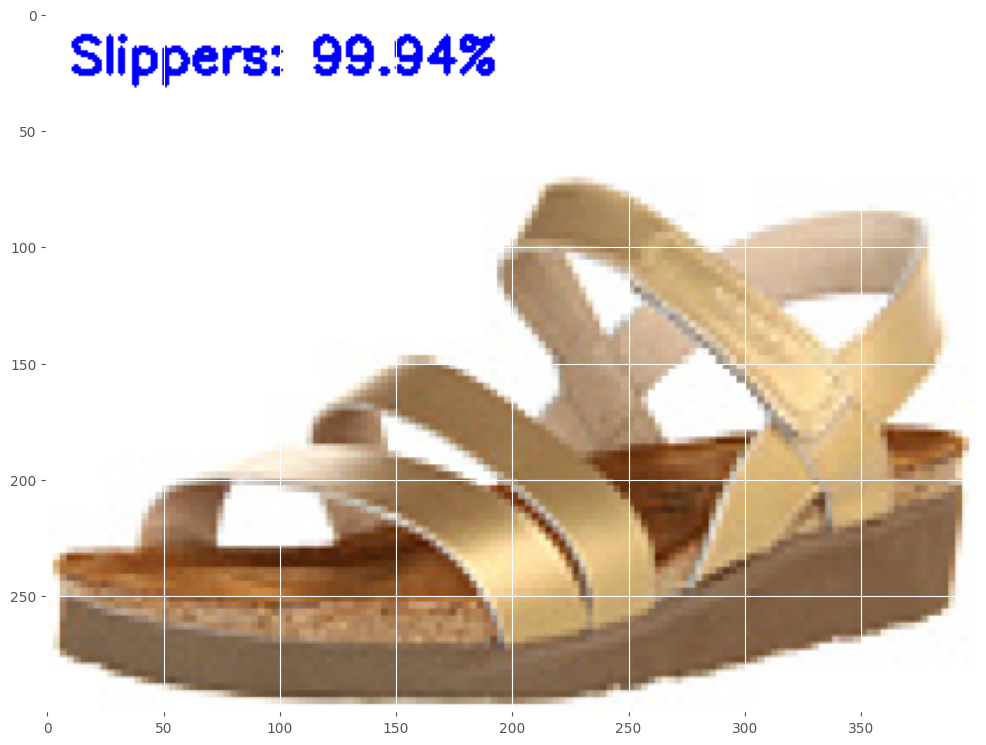

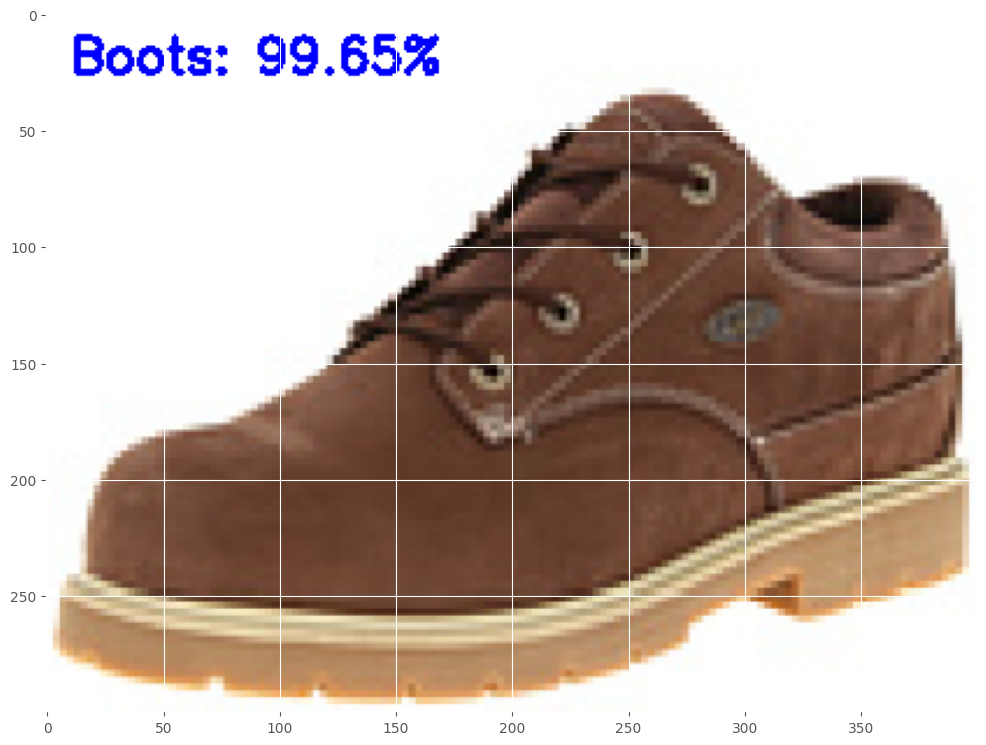

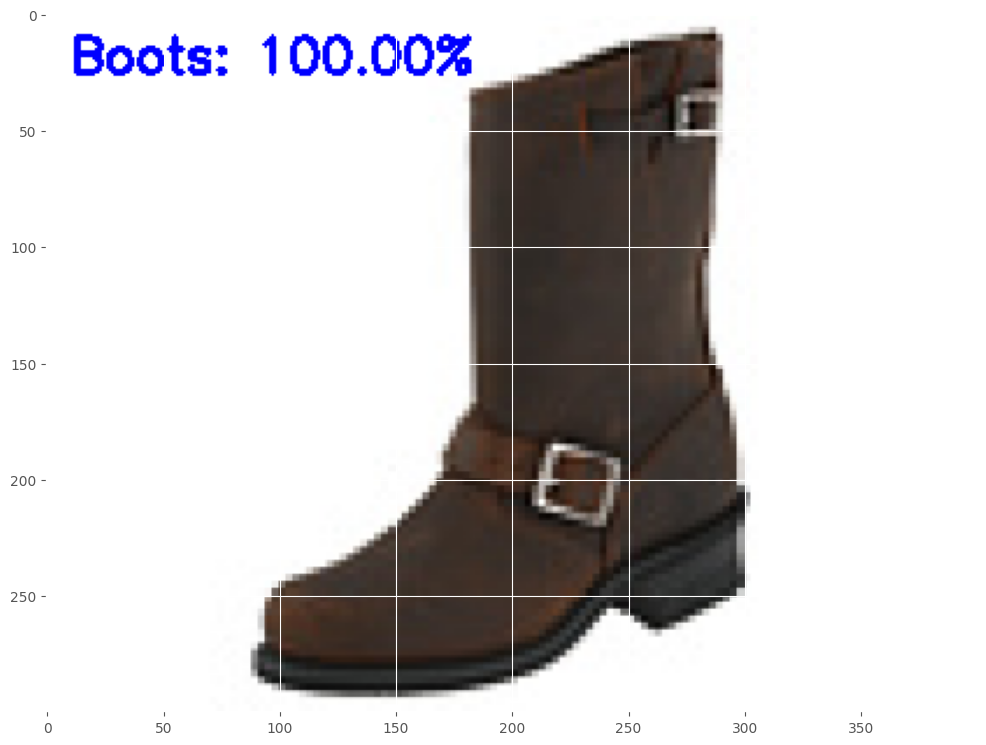

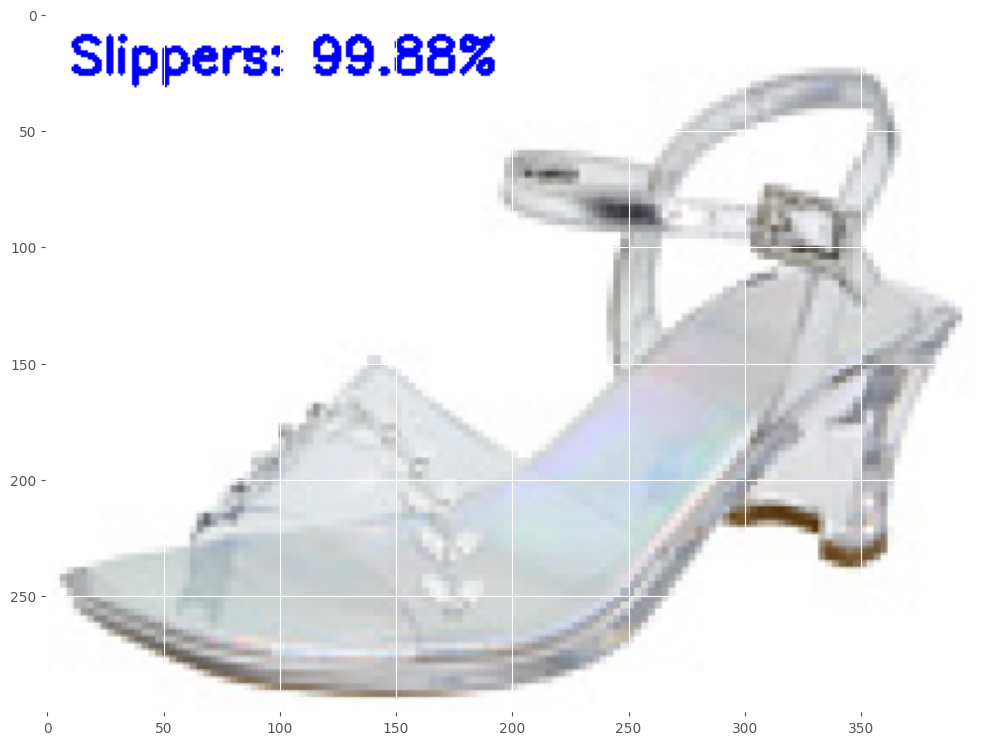

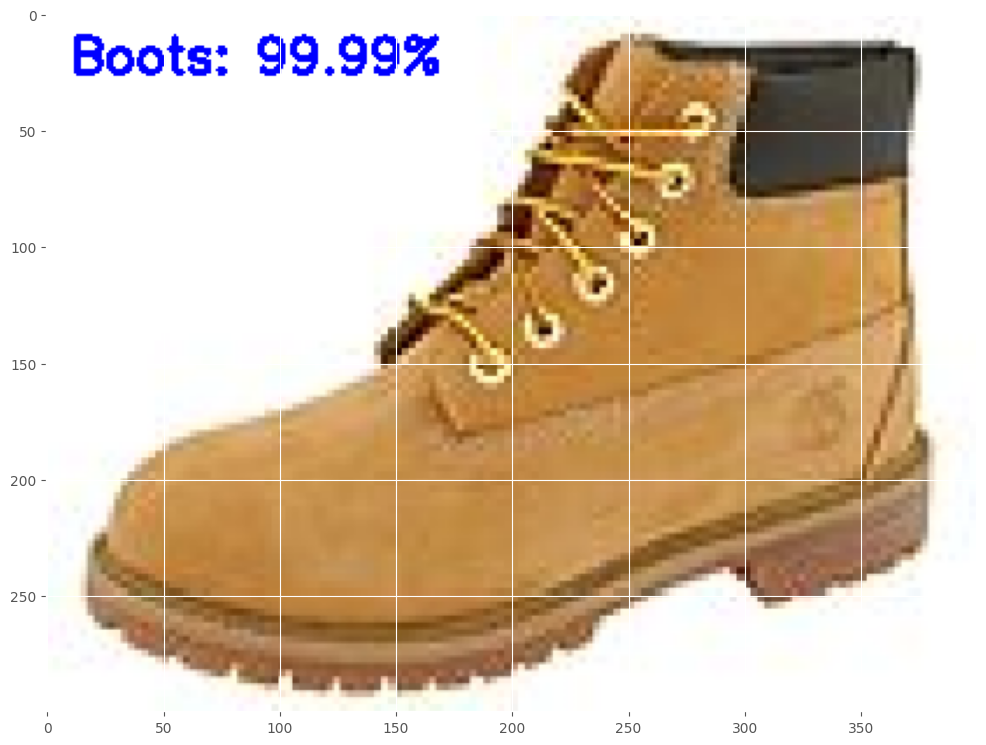

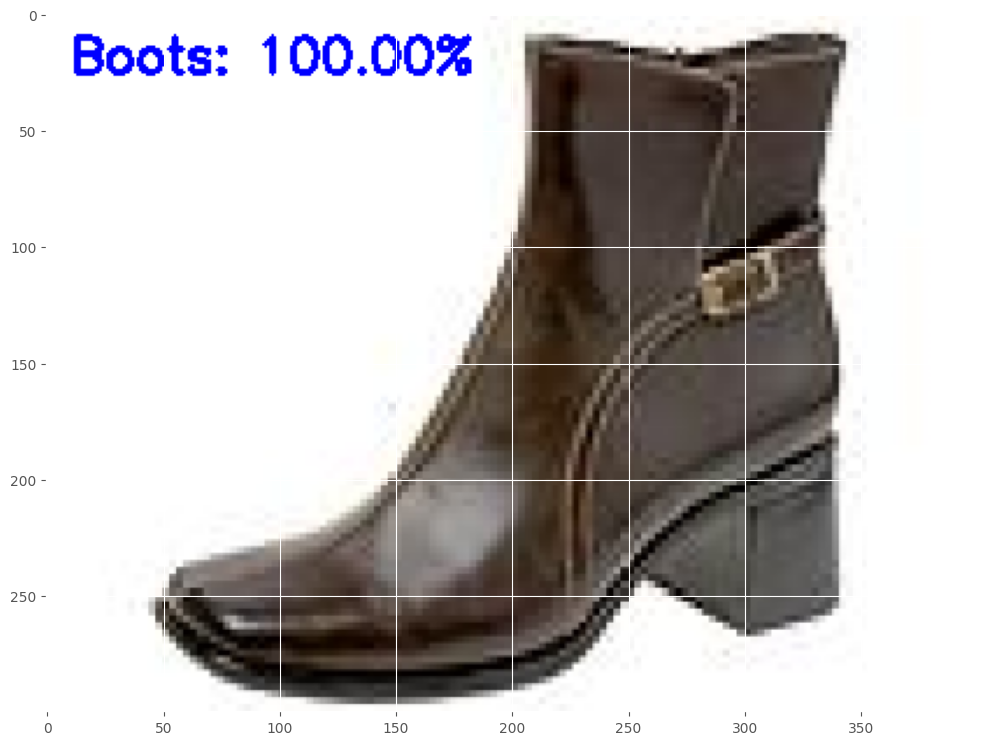

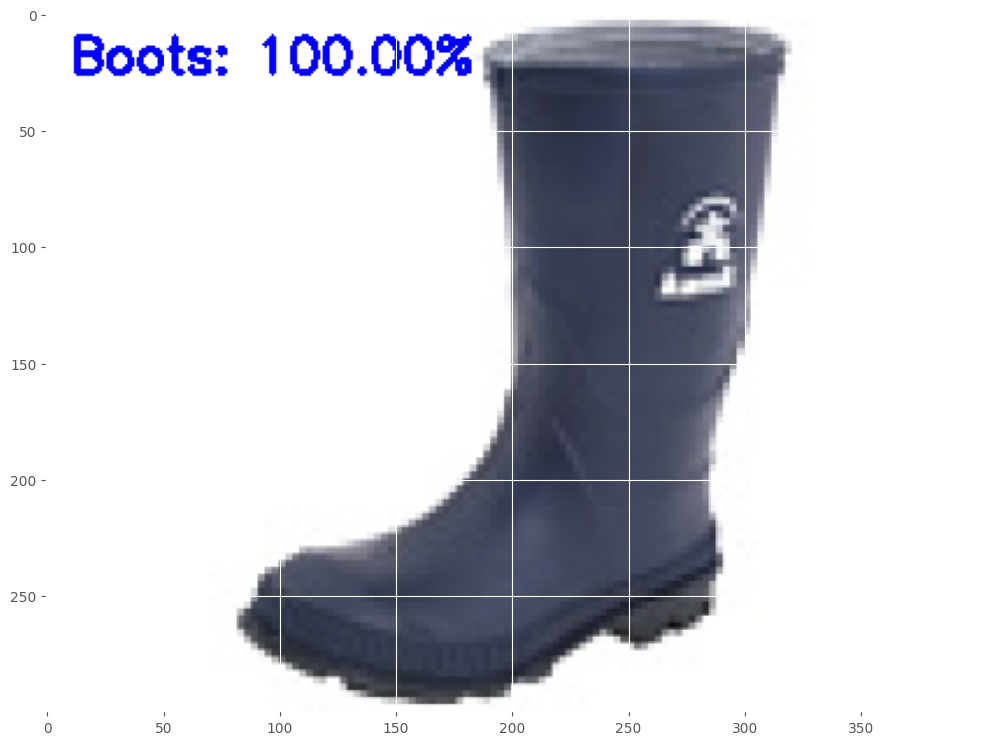

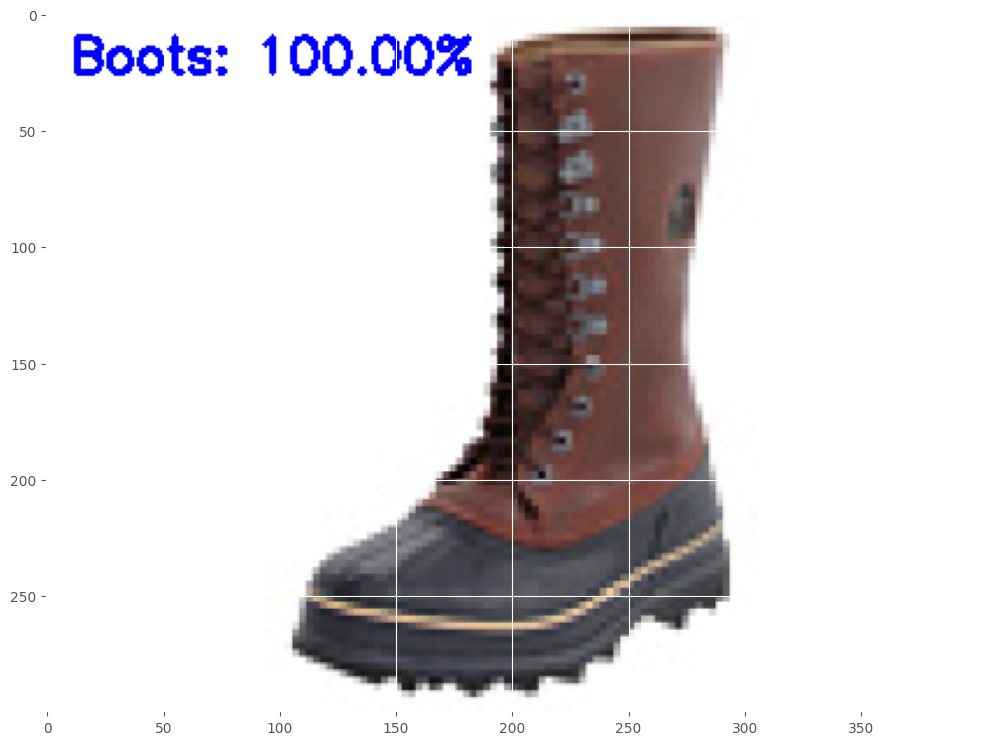

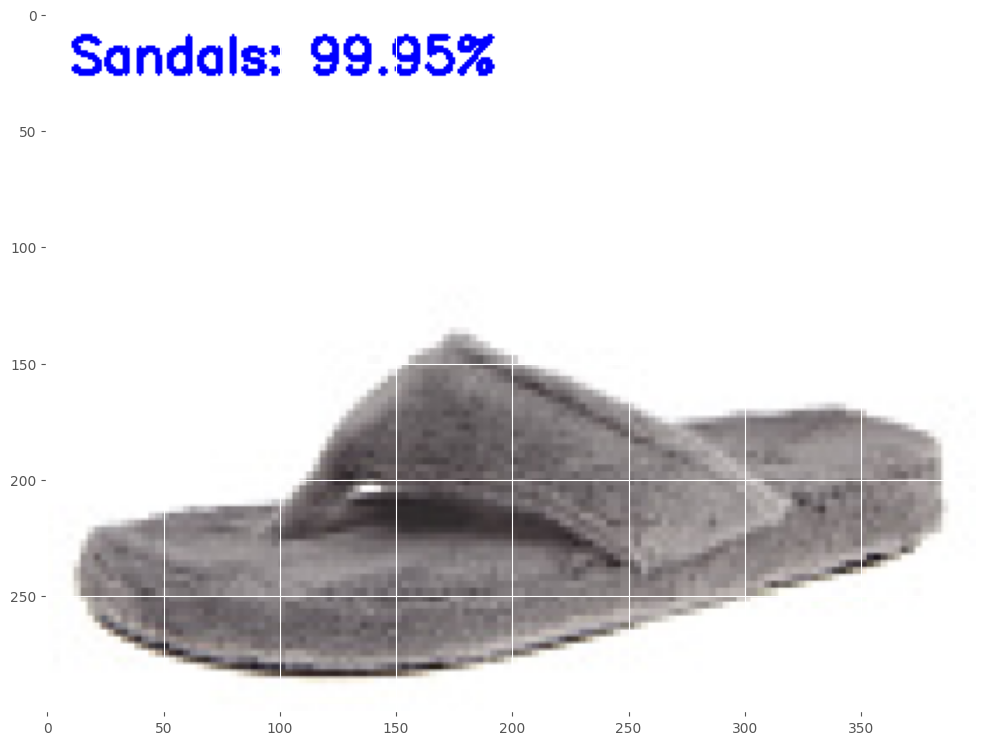

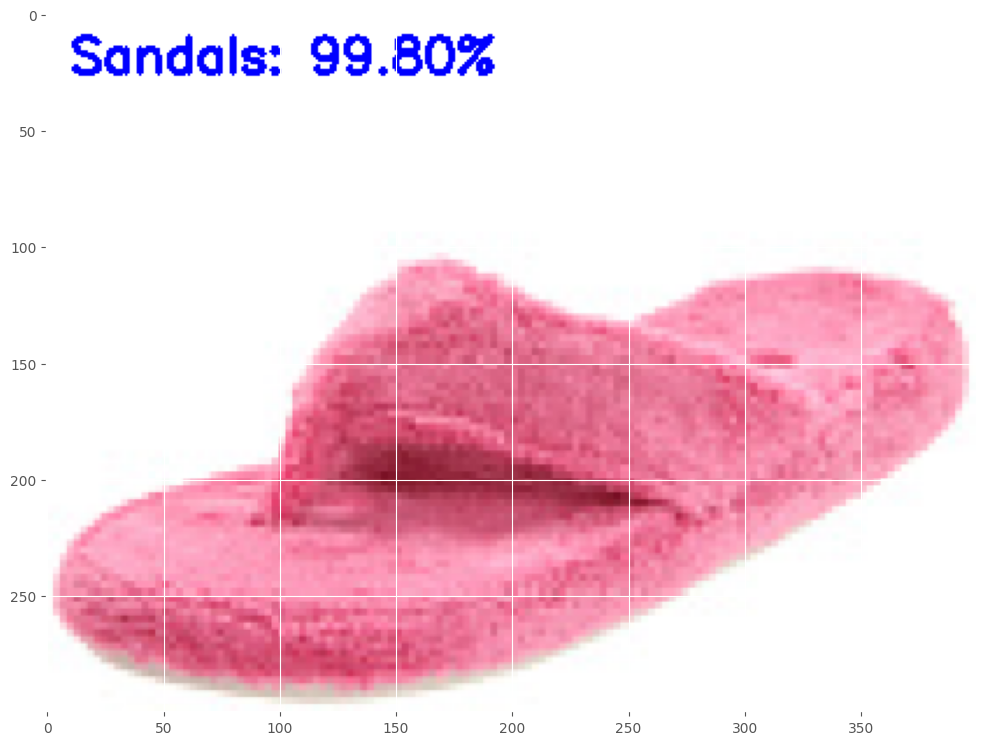

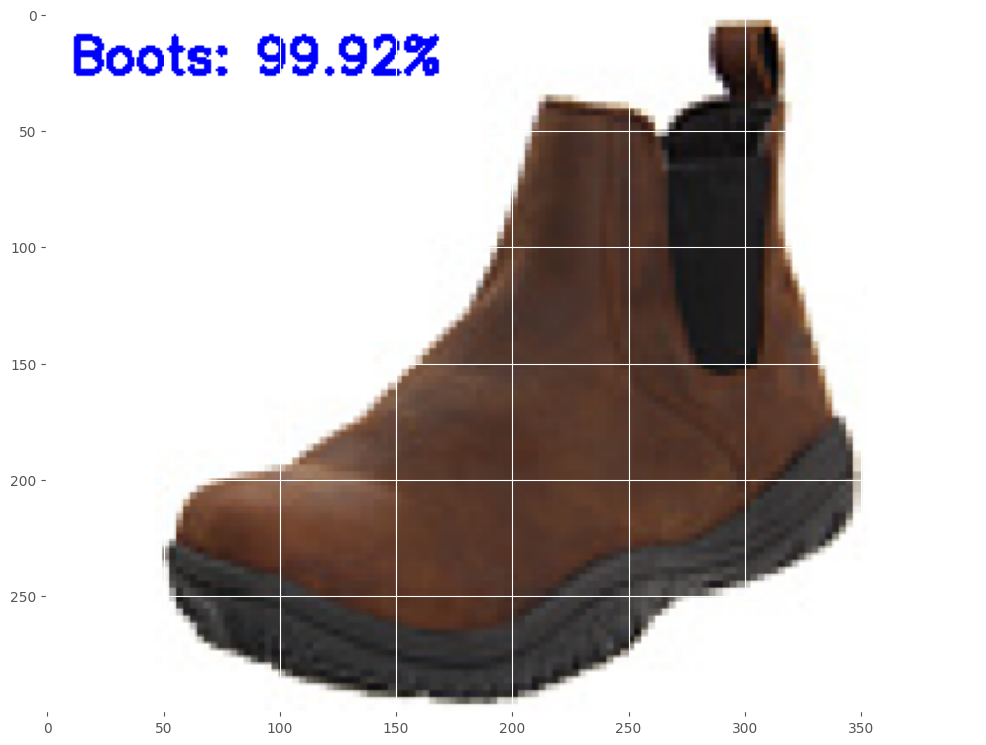

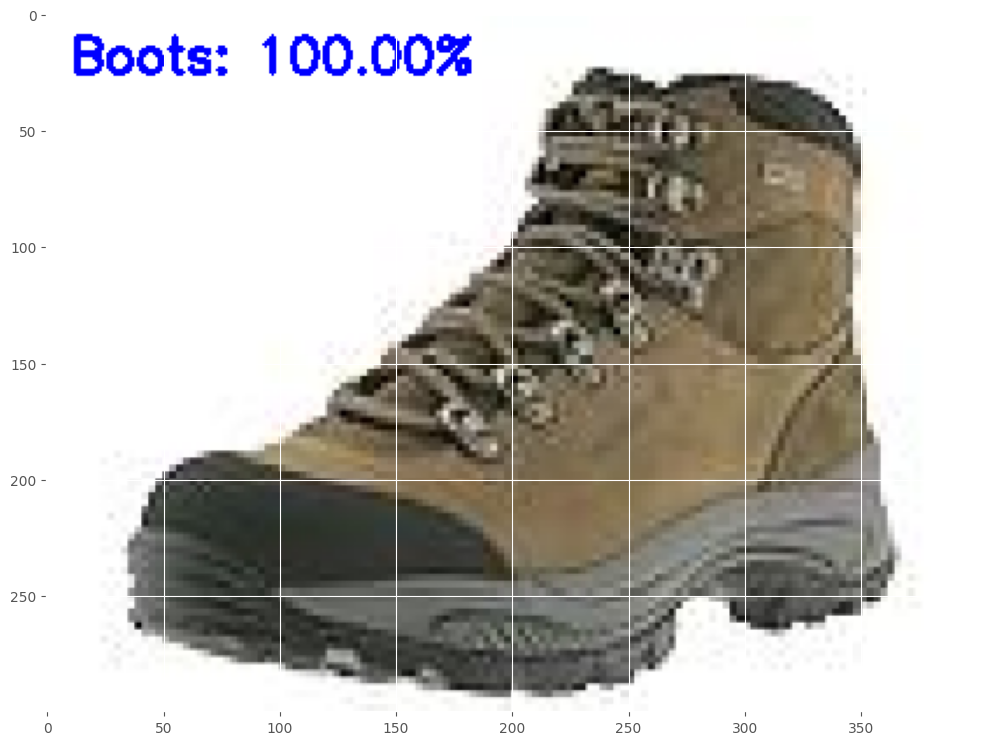

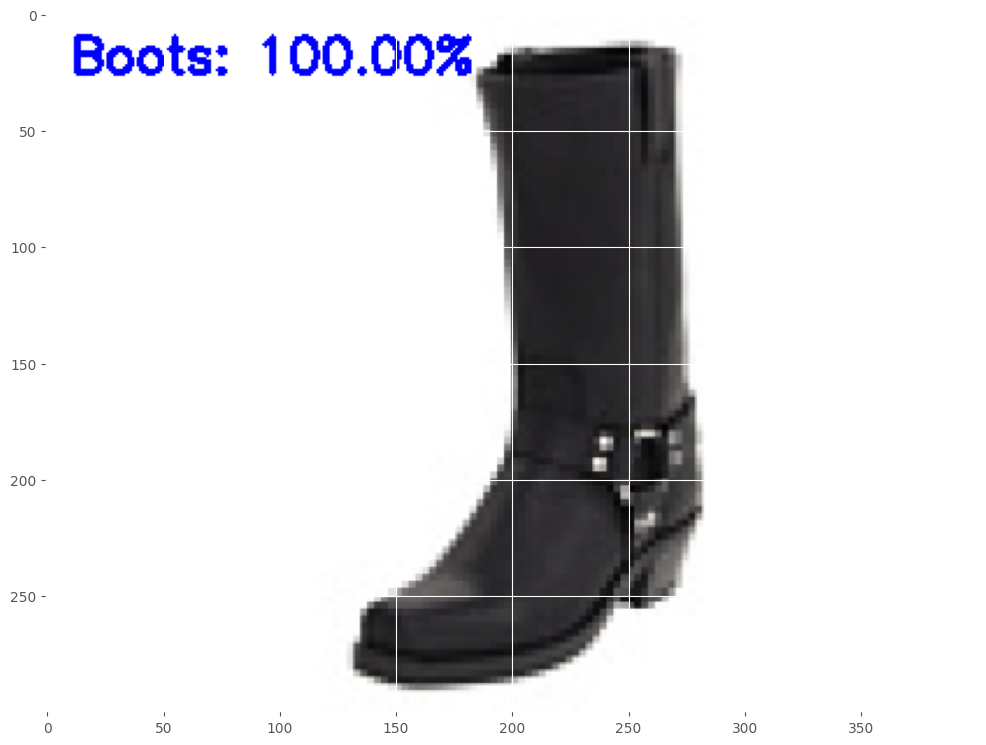

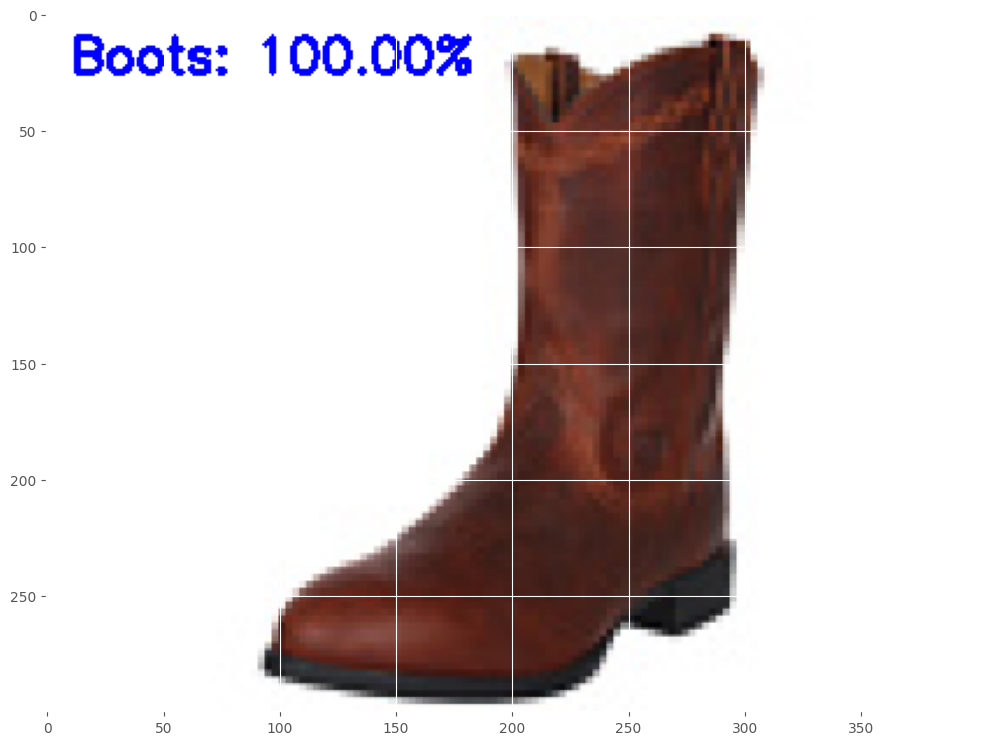

In [ ]:
import imutils

def display_img(img):
    fig = plt.figure(figsize=(12,10))
    # plt.grid(b=None)
    ax = fig.add_subplot(111)

    ax.imshow(img)
 



# import the necessary packages
from tensorflow.keras.models import load_model
import pickle
import cv2

# # load the model 
print("[INFO] loading network and...")
# model = load_model(MODEL)

# grab the image paths and randomly shuffle themt
testImagePaths = sorted(list(paths.list_images('test')))   

all_class = ["Boots", "Slippers", "Sandals"]


# progress bar 
with tqdm(total=len(testImagePaths)) as pbar:
    
    for imagePath in testImagePaths:
        
        # load the image
        image = cv2.imread(imagePath)
        orig = image.copy()

        # pre-process the image for classification
        image = cv2.resize(image, (28, 28))
        image = image.astype("float") / 255.0
        image = img_to_array(image)
        image = np.expand_dims(image, axis=0)

        # classify the input image
        prd_conf= model.predict(image)[0] # [[0.1 , 0.8 , 0.1]]
        print(prd_conf)

        # build the label
        label = all_class[np.argmax(prd_conf)] #[b f s]-> f
        proba = prd_conf[np.argmax(prd_conf)] # [0.1 , 0.8 , 0.1]  -> 0.8

        label = "{}: {:.2f}%".format(label, proba * 100)

        # draw the label on the image
        output = imutils.resize(orig, width=400)
        cv2.putText(output, label, (10, 25),  cv2.FONT_HERSHEY_SIMPLEX,
            0.7, (255, 0, 0), 2)
        
        # convert img to rgb format and display in notebook
        img = cv2.cvtColor(output, cv2.COLOR_BGR2RGB)
        display_img(img)
        
        pbar.update(1)




def predict_image(image):
    # load the image
    
    # pre-process the image for classification
    image = cv2.resize(image, (28, 28))
    image = image.astype("float") / 255.0
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)

        
    preds = model.predict(image)[0]
    result = dict()
    result["Boots"] = round(float(list(preds)[0]), 3)
    result["Slippers"] = round(float(list(preds)[1]), 3)
    result["Sandals"] = round(float(list(preds)[2]), 3)
    
    print(result)
   

    return result

In [ ]:
!pip install gradio

In [ ]:
import gradio as gr

In [ ]:

def predict_image(image):
    # load the image
    
    # pre-process the image for classification
    image = cv2.resize(image, (28, 28))
    image = image.astype("float") / 255.0
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)

        
    preds = model.predict(image)[0]
    result = dict()
    result["Boots"] = round(float(list(preds)[0]), 3)
    result["Slippers"] = round(float(list(preds)[1]), 3)
    result["Sandals"] = round(float(list(preds)[2]), 3)
    
    print(result)
   

    return result

In [ ]:
im = gr.inputs.Image(shape=(32,32))
label = gr.outputs.Label(num_top_classes=3)

gr.Interface(fn=predict_image, inputs=im, outputs=label, capture_session=True, title="CNN Demo").launch(share=True)